# Imports

In [15]:
# Imports
import sys
import os
module_dir = os.path.abspath('/sddata/projects/SSL/custom_mae/src/')
sys.path.append(module_dir)
import transformers
from transformers import ViTFeatureExtractor, ViTMAEForPreTraining
from monai.data import DataLoader, ArrayDataset
from sklearn.model_selection import train_test_split
import torch
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys
import time 
import PIL
import random
import pandas as pd

import models_mae
import torch.nn as nn

# Helper Functions

In [2]:
def show_image(image, feature_extractor, title=''):
    # image is [H, W, 3]
    imagenet_mean = np.array(feature_extractor.image_mean)
    imagenet_std = np.array(feature_extractor.image_std)
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model, feature_extractor):
    # forward pass
    outputs = model(pixel_values) # We note here that using ViTMAEForPreTraining we get a dictionary of odict_keys(['loss', 'logits', 'mask', 'ids_restore'])
    # and if using prepare model we get a tuple of (loss, y = logits, mask), so we need to take both into account
    try:
        y = model.unpatchify(outputs.logits)
    except:
        y = outputs[1]
        y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    try:
        mask = outputs.mask.detach()
    except:
        mask = outputs[2]
    try:
        mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    except:
        mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], feature_extractor, "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], feature_extractor, "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], feature_extractor, "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], feature_extractor, "reconstruction + visible")

    plt.show()

# Configure Devices

def configure_devices(model, device_ids):
    ''' Method to enforce parallelism during model training '''
    if  len(device_ids) > 1: #isinstance(device_ids, list): # for multiple GPU training
        print(f'Using multiple GPUS: {device_ids}')
        base_device = 'cuda:{}'.format(device_ids[0])
        model.to(base_device)
        model = nn.DataParallel(model, device_ids=device_ids)
    elif len(device_ids) == 1 and device_ids[0].isdigit(): # for single GPU training
        print(f'Using GPU ', device_ids[0])
        base_device = 'cuda:' + device_ids[0]
        model = model.to(base_device)
    else:
        print('Using CPU')
        base_device = 'cpu' # for CPU based training
        model = model.to('cpu')

    return base_device

# Data

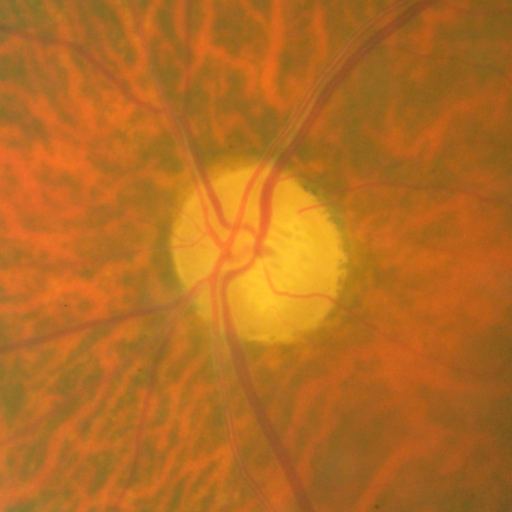

In [3]:
image_path = '/projects/Fundus_Segmentation/Organized_Datasets/Riga_Organized/Cropped/Prime/MagrabiaMale_image1-4.png'
image = Image.open(image_path)
image

# Inference

In [4]:
torch.manual_seed(2)

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.


ViTMAEForPreTraining outputs: ViTMAEForPreTrainingOutput(loss=tensor(0.0256, grad_fn=<DivBackward0>), logits=tensor([[[ 0.8723, -0.1201, -1.0325,  ...,  0.8777, -0.1580, -1.0947],
         [ 0.8404, -0.1717, -1.0887,  ...,  0.9042, -0.2050, -1.1004],
         [ 0.4789, -0.1175, -0.5895,  ...,  0.3473, -0.2832, -0.6912],
         ...,
         [ 0.4324, -0.2801, -0.7436,  ...,  0.0515, -0.3749, -0.7433],
         [ 0.5071, -0.4617, -1.2639,  ...,  0.3915, -0.4616, -1.2882],
         [ 0.4622, -0.4952, -1.2879,  ...,  0.3023, -0.5058, -1.2814]]],
       grad_fn=<SliceBackward0>), mask=tensor([[1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
     

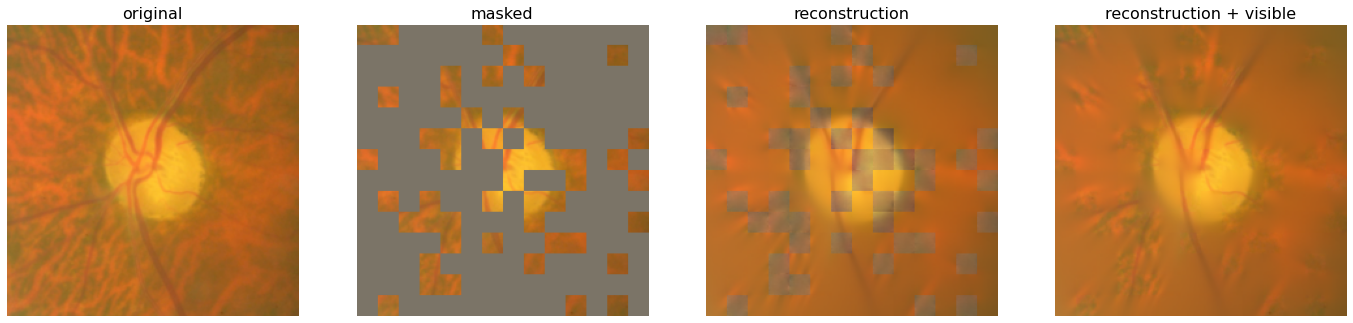

In [8]:
facebook_model = 'facebook/vit-mae-base'
feature_extractor = ViTFeatureExtractor.from_pretrained(facebook_model)
model = ViTMAEForPreTraining.from_pretrained(facebook_model)
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
outputs = model(pixel_values)
print(f'ViTMAEForPreTraining outputs: {outputs}, {outputs.keys()}')
visualize(pixel_values, model, feature_extractor)

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.


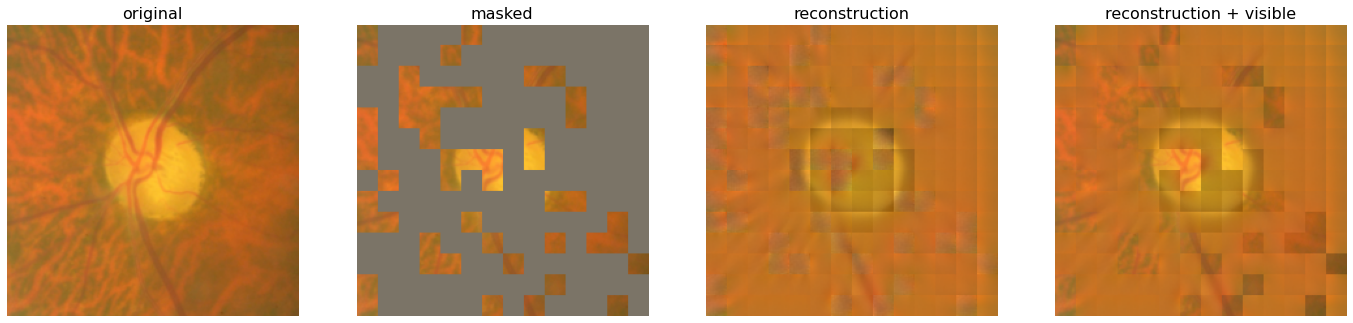

In [6]:
fine_tuned_facebook_model = '/projects/Cervical_Cancer_Projects/SSL/mae_hf/outputs_8_16_facebook_mae_base'
feature_extractor = ViTFeatureExtractor.from_pretrained(fine_tuned_facebook_model)
model = ViTMAEForPreTraining.from_pretrained(fine_tuned_facebook_model)
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize(pixel_values, model, feature_extractor)

In [19]:
def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False) # Note, if we are using a fine-tuned version, we need to have checkpoint['model']. Why?
    # msg = model.load_state_dict(checkpoint, strict=False) # Note, if we are using a fine-tuned version, we need to have checkpoint['model']. Why?
    print(msg)
    return model

<All keys matched successfully>


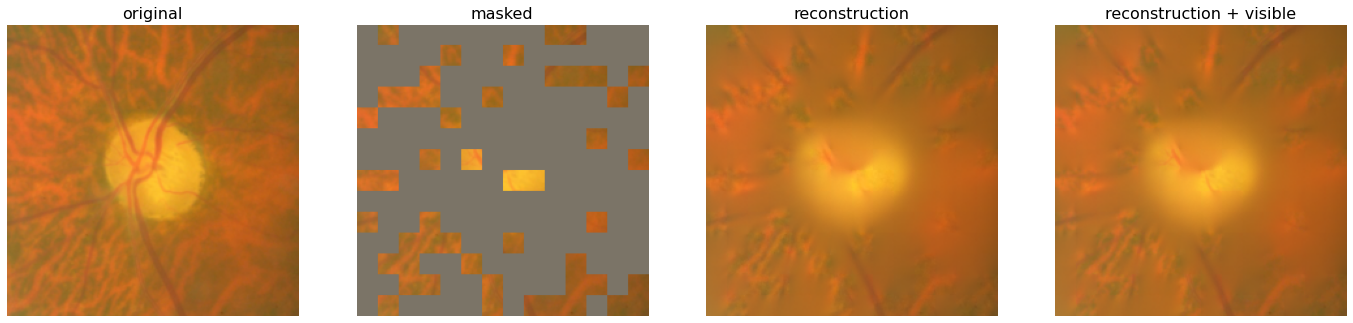

tensor(0.0218, grad_fn=<DivBackward0>)


In [18]:
# Loading from an architecure and weights

gan_loss_weights = '/projects/Cervical_Cancer_Projects/SSL/mae_facebook/demo/mae_visualize_vit_large_ganloss.pth'
gan_loss_weights_ft = '/projects/Cervical_Cancer_Projects/SSL/custom_mae/Reconstruction_Finetune_Best_Models/GAN_Loss_Large_Patch16_Cervix_Finetune_best_epoch.pth'

gan_loss_arch = 'mae_vit_large_patch16'
model = prepare_model(gan_loss_weights_ft, gan_loss_arch)
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
loss, y, mask = model(pixel_values.float(), mask_ratio=0.75)
visualize(pixel_values, model, feature_extractor)
print(loss)
# print(loss, y, mask)

<All keys matched successfully>


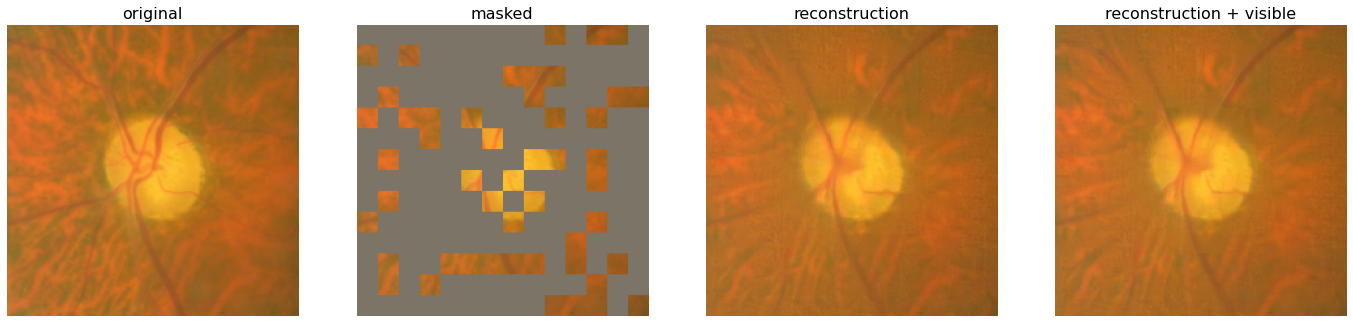

tensor(0.0227, grad_fn=<DivBackward0>)


In [20]:
model = prepare_model(gan_loss_weights, gan_loss_arch)
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
loss, y, mask = model(pixel_values.float(), mask_ratio=0.75)
visualize(pixel_values, model, feature_extractor)
print(loss)

# Training Pipeline for Non-Configured Models (Architecture and Weights)

## Model and Feature Extractor

<All keys matched successfully>


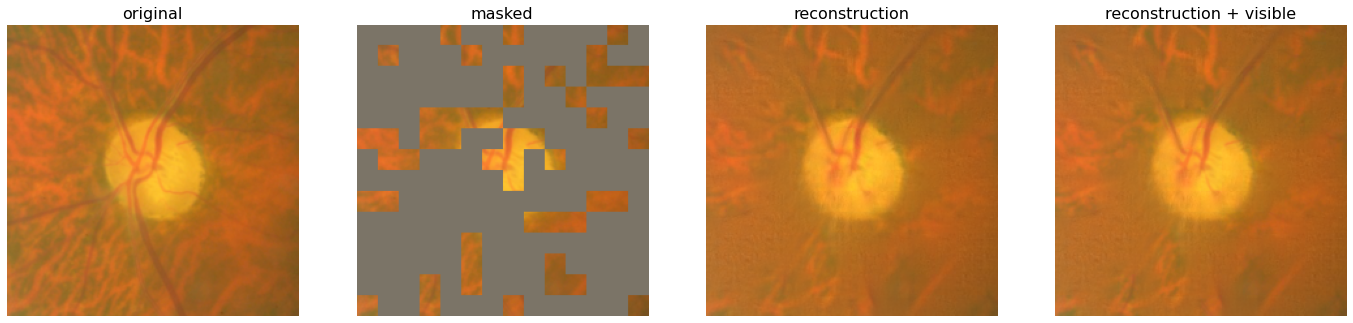

In [ ]:
gan_loss_weights = '/projects/Cervical_Cancer_Projects/SSL/mae_facebook/demo/mae_visualize_vit_large_ganloss.pth'
gan_loss_arch = 'mae_vit_large_patch16'
model = prepare_model(gan_loss_weights, gan_loss_arch)
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
loss, y, mask = model(pixel_values, mask_ratio=0.75)
visualize(pixel_values, model, feature_extractor)
# print(loss, y, mask)

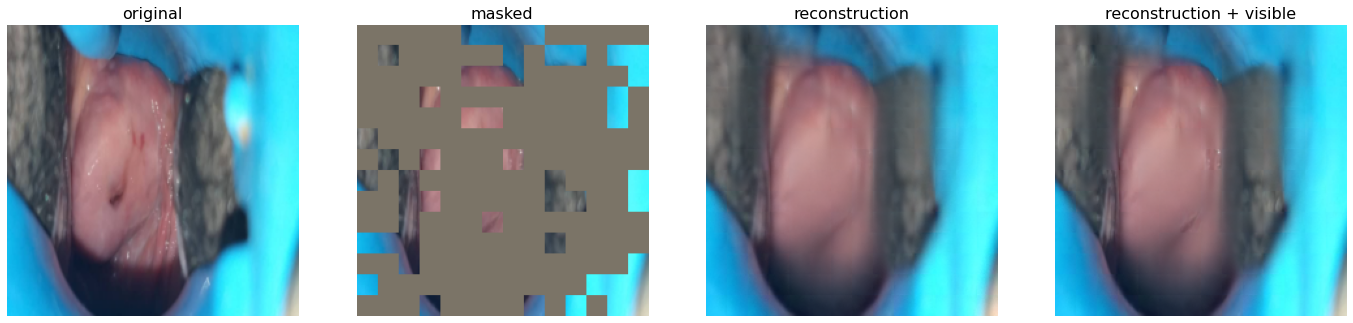

In [ ]:
image_path_cervix = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/ZRQB-00000505.jpg'
image_cervix = Image.open(image_path_cervix)
pixel_values = feature_extractor(image_cervix, return_tensors="pt").pixel_values
visualize(pixel_values, model, feature_extractor)

In [12]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

## Data Organization

In [13]:
data_dir = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual'
all_images = os.listdir(data_dir)
all_images = [os.path.join(data_dir, image) for image in all_images]
print(f'There are {len(all_images)} images. Example of an image path: {all_images[0]}')

There are 59502 images. Example of an image path: /projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/I183005_C2.jpg


In [14]:
all_images = all_images[:256]
dataset_pixel_values = [feature_extractor(Image.open(image), return_tensors="pt").pixel_values for image in all_images]
print(f'Dataset values and shape after feature_extractor: {dataset_pixel_values[0], dataset_pixel_values[0].shape}')

Dataset values and shape after feature_extractor: (tensor([[[[-2.0323, -2.0323, -2.0152,  ..., -1.9809, -1.9980, -2.0323],
          [-2.0323, -2.0323, -2.0152,  ..., -1.9980, -1.9980, -2.0323],
          [-2.0323, -2.0323, -2.0152,  ..., -1.9809, -1.9980, -2.0323],
          ...,
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0323, -2.0323, -2.0323,  ..., -2.0323, -2.0323, -2.0323],
          [-2.0152, -2.0152, -2.0152,  ..., -2.0152, -2.0323, -2.0323]],

         [[-1.9657, -1.9657, -1.9657,  ..., -1.9482, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9482, -1.9657, -1.9657],
          ...,
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657],
          [-1.9657, -1.9657, -1.9657,  ..., -1.9657, -1.9657, -1.9657]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044

## Training Loop

In [ ]:
#  Data Prep

import random

data_list_copy = dataset_pixel_values.copy()  # Create a copy of the original list

# Set the random seed for reproducibility (optional)
random.seed(42)

# Define the percentage of data to be used for validation (e.g., 20%)
validation_split = 0.2

# Calculate the number of samples for the validation set
num_samples = len(data_list_copy)
num_validation_samples = int(validation_split * num_samples)

# Randomly shuffle the data
random.shuffle(data_list_copy)

# Split the data into training and validation sets
validation_data = data_list_copy[:num_validation_samples]
train_data = data_list_copy[num_validation_samples:]


batch_size = 32

train_dataloader = DataLoader([prepped_data.squeeze(0) for prepped_data in train_data], batch_size = batch_size, shuffle = False)
val_dataloader = DataLoader([prepped_data.squeeze(0) for prepped_data in validation_data], batch_size = batch_size, shuffle = False)

base_device = configure_devices(model, ['0'])

In [25]:
# Training parameters

learning_rate = 1e-5
epochs = 1

model_directory = '/projects/Cervical_Cancer_Projects/SSL/Testing/GAN_Loss_Fine_Tuning'
title = 'GAN_Loss_Fine_Tune_Cervix'

In [26]:
# Training and validation loop

start = time.time()

val_interval = 1

train_loss_values = []
val_loss_values = []

optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

for epoch in range(epochs):

        ## Epoch tracking
        print("-" * 10)
        print(f"epoch {epoch + 1}/{epochs}")

        model.train() # Making sure we are in train mode, as we have both dropout and batch normalization we want running

        ## Initializing epoch loss and step, as we will have to find the average of loss versus steps
        train_loss = 0 # Epoch train loss
        step = 0

        ## Stepping through the batches
        for batch_data in train_dataloader: # Ranging over the batches
            step += 1 # Counting the batches
            input = batch_data
            optimizer.zero_grad() # Zeroing out the optimizer gradients

            loss, y, mask = model(input.to(base_device), mask_ratio=0.75)

            loss.backward() # Updating the parameters
            optimizer.step() # Updating the optimizer
            # scheduler.step()

            train_loss += loss.item() # Getting the loss and adding it to the total loss for this epoch
        
        ## Epoch loss calculation and printing
        train_loss /= step

        train_loss_values.append(train_loss)
        print(f'Train Epoch Loss {np.round(train_loss, 4)}')

    ## Validation
        if (epoch + 1) % val_interval == 0:

            model.eval() # Turning off the random components (dropout and batch norm) for evaluation
            ### Stepping through the validation batch
            with torch.no_grad(): # We are not updating any gradients during this
                val_loss = 0 # Epoch validation loss
                val_step = 0

                for batch_data in val_dataloader: # Running through the validation dataset batches
                    val_step += 1 # Counting the batches
                    val_input = batch_data

                    loss, y, mask = model(val_input.to(base_device), mask_ratio=0.75)

                    val_loss += loss.item() # Loss is only image-level hereval_loss += loss.item()

                val_loss /= val_step
                val_loss_values.append(val_loss) # Adding the average loss for this epoch validation iteration
                
            ### Printing our performance this validation iteration
            print(f'Val Epoch Loss {np.round(val_loss, 4)}')

                ## Plotting
        plt.figure(figsize=(10, 10))
        plt.plot(train_loss_values)
        plt.plot(val_loss_values)
        plt.legend(['Training Loss', 'Validation Loss'])
        plt.title('Training Performance')    
        plt.xlabel('Epoch')
        plt.ylabel('Loss')     
        plt.savefig(model_directory + title + '_performance.png')
        plt.close()

        ## Model weights saving
        ### Weight saving
        if val_loss_values[-1] == np.min(val_loss_values): # Checking if this epoch has the lowest validation. If so, we save it.
            savepath = '/projects/Cervical_Cancer_Projects/SSL/Testing/GAN_Loss_Fine_Tuning/' + title + "_best_epoch.pth"
            print("savepath: ", savepath)
            torch.save(model.state_dict(), savepath)
            print("saved model")
        else:
            print(f'Epoch {epoch+1} did not have as high performance as the previous, so we will not save these weights.')
                
        ### Model metrics saving
        np.save(os.path.join(model_directory, title + "_epoch_loss.npy"), train_loss_values)
        np.save(os.path.join(model_directory, title + "_val_loss.npy"), val_loss_values)

end = time.time()

print(f'We are done! This training took: {end-start} seconds.')


----------
epoch 1/1
tensor(0.1315, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1139, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1002, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0996, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0839, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1092, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1504, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1377, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2113, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1256, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0993, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1072, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1816, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1071, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0800, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.0773, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1483, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1220, device='cuda

positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.


saved model
We are done! This training took: 4.860243558883667 seconds.


# Loss Over Dataset Function

In [6]:
def feature_extraction_single_image_from_given_params(img_path, img_size, means, stand_devs):

    img = Image.open(img_path)
    img = img.resize((img_size, img_size))
    img = np.array(img) / 255.

    assert img.shape == (img_size, img_size, 3)

    # normalize by ImageNet mean and std
    img = img - means
    img = img / stand_devs

    return img

def prepare_dataset_from_dir(data_dir, feature_extractor, img_size, means, stand_devs):

    all_images = os.listdir(data_dir)
    all_images = [os.path.join(data_dir, image) for image in all_images]
    print(f'There are {len(all_images)} images. Example of an image path: {all_images[0]}')

    all_images = all_images[:256]

    if feature_extractor is not None: # If we have a feature extractor, this will prepare the dataset based on that
        print('We are using a feature extractor.')
        dataset_pixel_values = [feature_extractor(Image.open(image), return_tensors="pt").pixel_values for image in all_images]
        print(f'Example datum shape and min/max after feature_extractor: {dataset_pixel_values[0].shape, torch.min(dataset_pixel_values[0]), torch.max(dataset_pixel_values[0])}')

    else: # If instead, we have just the image size, means, and standard deviations
        print('We are using given parameters.')
        dataset_pixel_values = [feature_extraction_single_image_from_given_params(image, img_size, means, stand_devs) for image in all_images]
        print(f'Example datum shape and min/max after feature_extractor: {dataset_pixel_values[0].shape, torch.min(dataset_pixel_values[0]), torch.max(dataset_pixel_values[0])}')

    return dataset_pixel_values

import concurrent.futures

def process_image(image_path, feature_extractor, img_size, means, stand_devs):
    try:
        if image_path.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif", ".tif")):
            if feature_extractor is not None:
                image = Image.open(image_path)
                pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
            else:
                pixel_values = feature_extraction_single_image_from_given_params(image_path, img_size, means, stand_devs)
                pixel_values = torch.tensor(pixel_values).to(torch.float32)
                pixel_values = pixel_values.unsqueeze(dim=0)
                pixel_values = torch.einsum('nhwc->nchw', pixel_values)
            return pixel_values, image_path
        else:
            return None, None
    except (PIL.UnidentifiedImageError, OSError) as e:
        print(f"Error processing {image_path}: {e}")
        return None, None

def prepare_dataset_from_dir_parallel(data_dir, feature_extractor, img_size, means, stand_devs, num_rand_images):
    all_images = os.listdir(data_dir)
    all_images = [os.path.join(data_dir, image) for image in all_images]
    if num_rand_images is not None:
        all_images = random.sample(all_images, num_rand_images)

    valid_results = []

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_image, image_path, feature_extractor, img_size, means, stand_devs) for image_path in all_images]

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result[0] is not None:
                valid_results.append(result)

    # Separate pixel values and image paths
    dataset_pixel_values, valid_image_paths = zip(*valid_results)

    print(f'There are {len(dataset_pixel_values)} images. Example of an image path: {all_images[0]}')

    return list(dataset_pixel_values), list(valid_image_paths)

def calculate_average_loss_over_dataset(model, base_device, prepared_dataset, batch_size):

    dataloader = DataLoader([prepped_data.squeeze(0) for prepped_data in prepared_dataset], batch_size = batch_size, shuffle = False)

    overall_loss = 0

    for batch in dataloader:

        outputs = model(batch.to(base_device))
        try:
            loss_on_batch = outputs['loss']
        except:
            loss_on_batch = outputs[0]

        overall_loss += loss_on_batch.detach().cpu()

    return overall_loss/len(dataloader)

In [ ]:
# Testing on Facebook model

data_dir = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual'

facebook_model = 'facebook/vit-mae-base'
feature_extractor = ViTFeatureExtractor.from_pretrained(facebook_model)
model = ViTMAEForPreTraining.from_pretrained(facebook_model)

dataset_pixel_values = prepare_dataset_from_dir(data_dir, feature_extractor, None, None, None)
average_loss = calculate_average_loss_over_dataset(model, dataset_pixel_values, 32)

In [6]:
average_loss

tensor(0.1181, grad_fn=<DivBackward0>)

To do: 

1. Create create_model_from_pretrained function that returns the feature_extractor and the model. DONE!
2. Create create_model_from_arch_weights that returns the model. DONE!
3. For each of vacebook/vit-mae-base/large/huge run the dataset through to see what it does. In progress.
4. Test various '/projects/Cervical_Cancer_Projects/SSL/mae_facebook/demo/mae_visualize_vit_large_ganloss.pth' and 'mae_vit_large_patch16' to see if they exist/how they behave. DONE! They don't exist.
5. Move all this over to SSL? Try on cervices and fundus images. Done!


# Exploring why the fine-tuned doesn't do as well as we expect

In [ ]:
image_path_cervix = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/ZRQB-00000505.jpg'
image_cervix = Image.open(image_path_cervix)
pixel_values = feature_extractor(image_cervix, return_tensors="pt").pixel_values

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.


There are 100 images. Example of an image path: /projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/HFLD-00016923.jpg
tensor(0.0983)


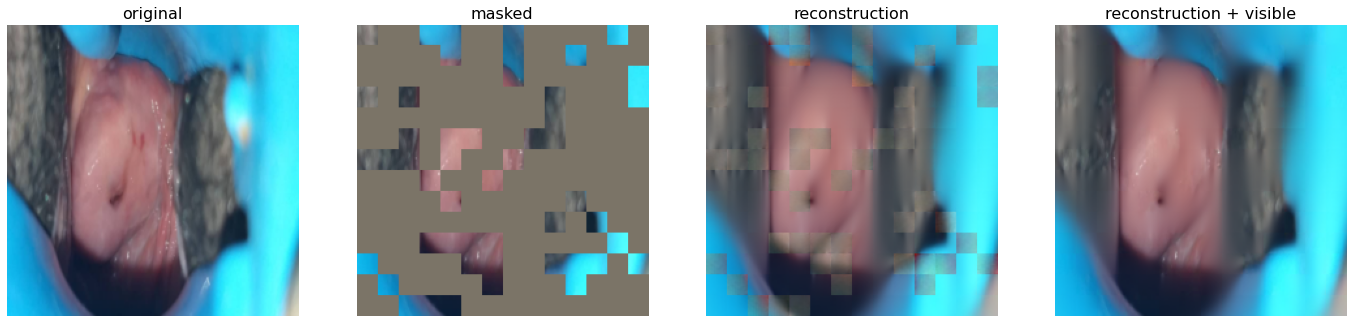

In [16]:
facebook_base = 'facebook/vit-mae-base'
facebook_base_hf_ft = '/projects/Cervical_Cancer_Projects/SSL/custom_mae/Reconstruction_Finetune_Best_Models/Facebook_Base_Cervix_HF_Finetune'

# Loading in the model from from_pretrained
feature_extractor_fb_b = ViTFeatureExtractor.from_pretrained(facebook_base)
model_fb_b = ViTMAEForPreTraining.from_pretrained(facebook_base)

feature_extractor_fb_b_ft = ViTFeatureExtractor.from_pretrained(facebook_base_hf_ft)
model_fb_b_ft = ViTMAEForPreTraining.from_pretrained(facebook_base_hf_ft)

image_path_cervix = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/ZRQB-00000505.jpg'
image_cervix = Image.open(image_path_cervix)
pixel_values = feature_extractor_fb_b(image_cervix, return_tensors="pt").pixel_values

data_dir = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual'
dataset_pixel_values, viable_paths = prepare_dataset_from_dir_parallel(data_dir, feature_extractor_fb_b, None, None, None, 100)
average_loss = calculate_average_loss_over_dataset(model_fb_b, 'cpu', dataset_pixel_values, 32)
print(average_loss)
visualize(pixel_values, model_fb_b, feature_extractor_fb_b)

<All keys matched successfully>
There are 100 images. Example of an image path: /projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/HFLD-00005823.jpg
tensor(0.0884)


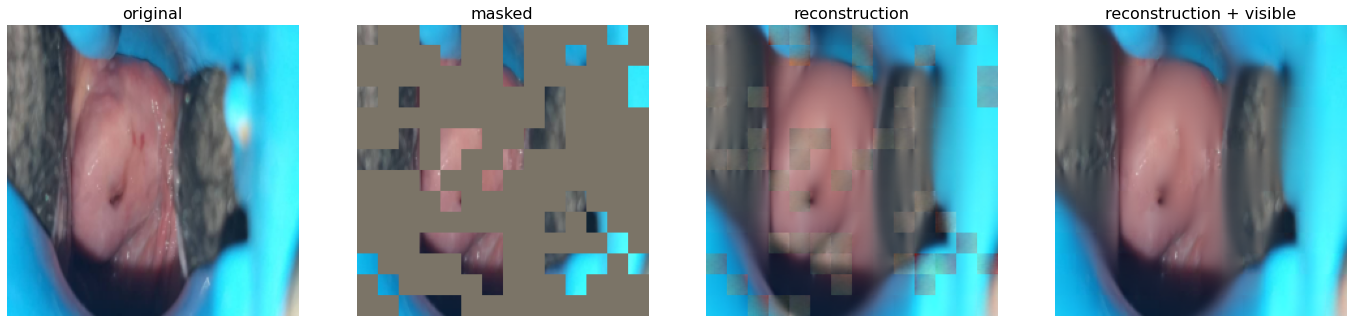

In [17]:
# Getting the model from the config and then just loading in weights that have been fine-tuned

chkpt_dir = '/projects/Cervical_Cancer_Projects/SSL/custom_mae/Reconstruction_Finetune_Best_Models/Facebook_Base_Cervix_Custom_Finetune_best_epoch.pth'
checkpoint = torch.load(chkpt_dir, map_location='cpu')
msg = model_fb_b.load_state_dict(checkpoint, strict=False)
print(msg)
dataset_pixel_values, viable_paths = prepare_dataset_from_dir_parallel(data_dir, feature_extractor_fb_b, None, None, None, 100)
average_loss = calculate_average_loss_over_dataset(model_fb_b, 'cpu', dataset_pixel_values, 32)
print(average_loss)
visualize(pixel_values, model_fb_b, feature_extractor_fb_b)

The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.


There are 100 images. Example of an image path: /projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/HFLD-00012075.jpg
tensor(0.2841)


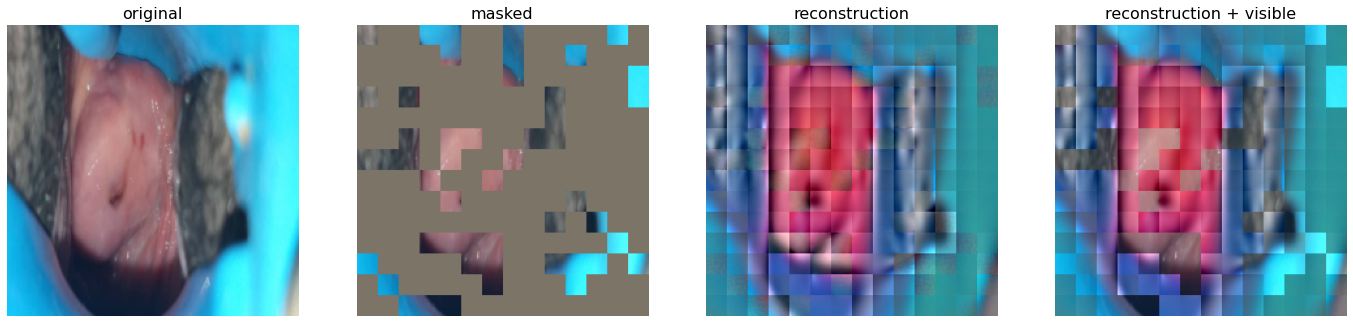

In [20]:
# Loading directly into the from_pretrained the hf-finetuned model

feature_extractor_fb_b_ft = ViTFeatureExtractor.from_pretrained(facebook_base_hf_ft)
model_fb_b_ft = ViTMAEForPreTraining.from_pretrained(facebook_base_hf_ft)

data_dir = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual'
dataset_pixel_values, viable_paths = prepare_dataset_from_dir_parallel(data_dir, feature_extractor_fb_b_ft, None, None, None, 100)
average_loss = calculate_average_loss_over_dataset(model_fb_b_ft, 'cpu', dataset_pixel_values, 32)
print(average_loss)
visualize(pixel_values, model_fb_b_ft, feature_extractor_fb_b_ft)

There are 100 images. Example of an image path: /projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/PUBL00010911.jpg
tensor(0.2465)


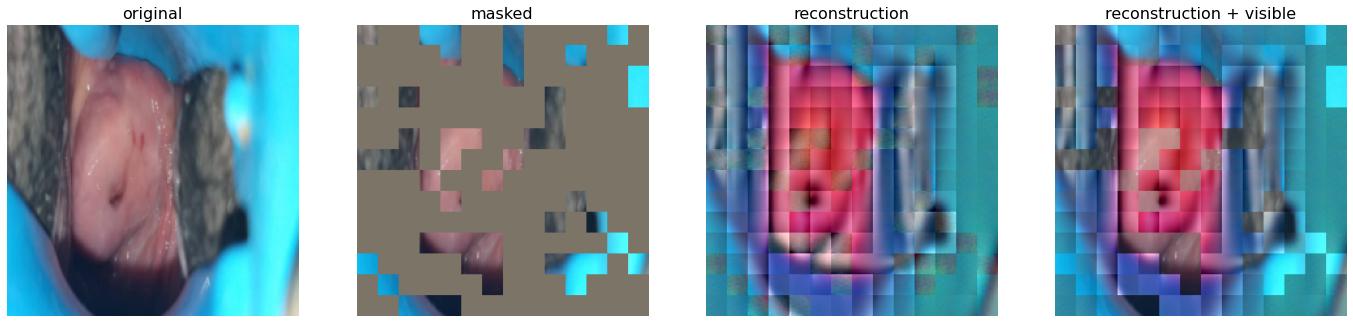

In [19]:
# Loading directly into the from_pretrained the hf-finetuned model. Testing different paths

facebook_base_hf_ft_testing = '/projects/Cervical_Cancer_Projects/SSL/custom_mae/Reconstruction_Finetune_Best_Models/Facebook_Base_Cervix_HF_Finetune/checkpoint-500'
feature_extractor_fb_b_ft = ViTFeatureExtractor.from_pretrained(facebook_base_hf_ft_testing)
model_fb_b_ft = ViTMAEForPreTraining.from_pretrained(facebook_base_hf_ft_testing)

data_dir = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual'
dataset_pixel_values, viable_paths = prepare_dataset_from_dir_parallel(data_dir, feature_extractor_fb_b_ft, None, None, None, 100)
average_loss = calculate_average_loss_over_dataset(model_fb_b_ft, 'cpu', dataset_pixel_values, 32)
print(average_loss)
visualize(pixel_values, model_fb_b_ft, feature_extractor_fb_b_ft)

positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.


There are 100 images. Example of an image path: /projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/PA172-1.jpg
tensor(0.2639)


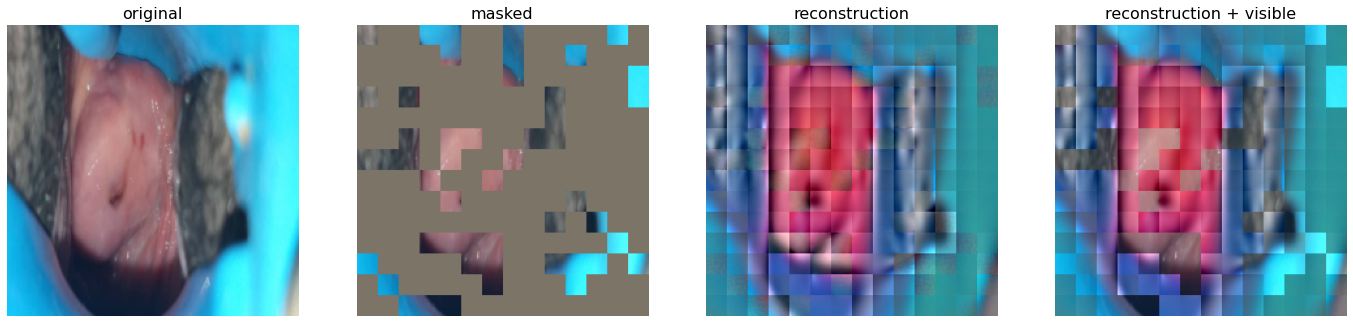

In [42]:
facebook_base_cervix_hg_ft = '/projects/Cervical_Cancer_Projects/SSL/custom_mae/Reconstruction_HuggingFace_Finetuning_Models/Cervix/Facebook_Base_Cervix_HF_Finetune'
feature_extractor = ViTFeatureExtractor.from_pretrained(facebook_base_cervix_hg_ft)
model = ViTMAEForPreTraining.from_pretrained(facebook_base_cervix_hg_ft)

image_path_cervix = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/ZRQB-00000505.jpg'
image_cervix = Image.open(image_path_cervix)
pixel_values = feature_extractor(image_cervix, return_tensors="pt").pixel_values

data_dir = '/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual'
dataset_pixel_values, viable_paths = prepare_dataset_from_dir_parallel(data_dir, feature_extractor, None, None, None, 100)
average_loss = calculate_average_loss_over_dataset(model, 'cpu', dataset_pixel_values, 32)
print(average_loss)
visualize(pixel_values, model, feature_extractor)

# Fundus CSV Creation

In [4]:
import os
import glob
import cv2
import numpy as np
from concurrent.futures import ProcessPoolExecutor

# Define the directory where your images are located
# root_directory = '/sddata/data/retina_datasets'
root_directory = '/sddata/projects/Fundus_Segmentation/Organized_Datasets'

# Define the list of image file extensions you want to collect
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif', '*.bmp', '*.tif']

# Initialize an empty list to store the image file paths
image_paths = []

# Recursively traverse the directory and collect image file paths
for extension in image_extensions:
    image_paths.extend(glob.glob(os.path.join(root_directory, '**', extension), recursive=True))

    
print(image_paths[0], len(image_paths))

# Function to check if an image is a mask
def is_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is not None:
        unique_values = np.unique(img)
        if len(np.array(img).shape) == 3 and img.shape[2] == 3 and len(unique_values) >4 and 'essel' not in image_path and 'ask' not in image_path and 'Cropped' in image_path:
            return True
    else:
        return False

# Define the number of parallel processes
num_processes = os.cpu_count()  # Use the number of available CPU cores

# Use ProcessPoolExecutor for parallel processing
with ProcessPoolExecutor(max_workers=num_processes) as executor:
    paths_that_are_images = list(executor.map(is_image, image_paths))

# Filter out the mask images
filtered_image_paths = [image_paths[i] for i, is_path_image in enumerate(paths_that_are_images) if is_path_image]

# Now, 'filtered_image_paths' contains the paths to non-mask images
print(filtered_image_paths[0], len(filtered_image_paths))

all_fundus_dict = {'Image': filtered_image_paths}
all_fundus_df = pd.DataFrame(all_fundus_dict)
all_fundus_df.to_csv('/sddata/projects/SSL/custom_mae/csvs/all_cropped_fundus_images.csv')

/sddata/projects/Fundus_Segmentation/Organized_Datasets/Drishti_Organized/Uncropped/Ring_and_Cup_Segmentations/drishtiGS_052_1.png 63081
/sddata/projects/Fundus_Segmentation/Organized_Datasets/Drishti_Organized/Cropped/Images/drishtiGS_035.png 5340


# Converting all the images to numpy arrays 

In [ ]:
import os
import numpy as np
import multiprocessing
from PIL import Image

# Function to convert an image to a numpy array
def image_to_array(image_path):
    try:
        with Image.open(image_path) as img:
            return np.array(img)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Function to process a batch of images and save them as numpy arrays
def process_images_in_batch(image_batch, output_directory):
    for image_path in image_batch:
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        numpy_array = image_to_array(image_path)
        if numpy_array is not None:
            numpy_file_path = os.path.join(output_directory, f"{image_name}.npy")
            np.save(numpy_file_path, numpy_array)

input_directory = '/sddata/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual'
output_directory = '/sddata/projects/Cervical_Cancer_Projects/data/numpy_arrays/full_dataset_duke_liger_itoju_5StLowQual_np_arr'
num_processes = multiprocessing.cpu_count()

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

image_paths = [os.path.join(input_directory, filename) for filename in os.listdir(input_directory) if filename.endswith((".jpg", ".png"))]

chunk_size = len(image_paths) // num_processes

# Split the list of image paths into chunks for parallel processing
image_path_chunks = [image_paths[i:i + chunk_size] for i in range(0, len(image_paths), chunk_size)]

pool = multiprocessing.Pool(processes=num_processes)

# Process images in parallel
pool.starmap(process_images_in_batch, [(image_chunk, output_directory) for image_chunk in image_path_chunks])

pool.close()
pool.join()

print("Conversion of images to numpy arrays complete.")

(2891, 1973)


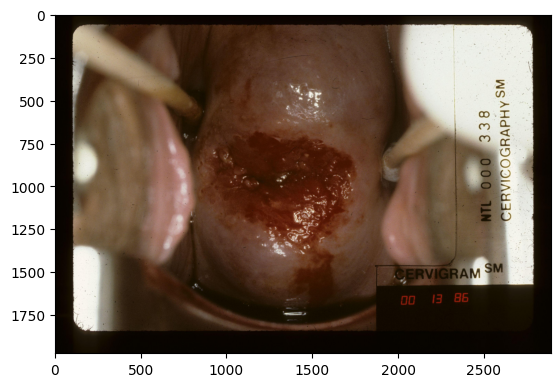

In [62]:
import os
import numpy as np
import multiprocessing
from PIL import Image
import matplotlib.pyplot as plt

def image_to_array(image_path):
    try:
        with Image.open(image_path) as img:
            print(img.size)
            return Image.fromarray(np.array(img))
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

img_path = '/sddata/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/I217117_C1.jpg'

img_ar = image_to_array(img_path)
plt.imshow(img_ar)


In [61]:
from PIL.ExifTags import TAGS
image = Image.open(img_path)
# extract other basic metadata
info_dict = {
    "Filename": image.filename,
    "Image Size": image.size,
    "Image Height": image.height,
    "Image Width": image.width,
    "Image Format": image.format,
    "Image Mode": image.mode,
    "Image is Animated": getattr(image, "is_animated", False),
    "Frames in Image": getattr(image, "n_frames", 1)
}

for label,value in info_dict.items():
    print(f"{label:25}: {value}")

# extract EXIF data
exifdata = image.getexif()
print(exifdata)

# iterating over all EXIF data fields
for tag_id in exifdata:
    # get the tag name, instead of human unreadable tag id
    tag = TAGS.get(tag_id, tag_id)
    data = exifdata.get(tag_id)
    # decode bytes 
    if isinstance(data, bytes):
        data = data.decode()
    print(f"{tag:25}: {data}")

Filename                 : /sddata/projects/Cervical_Cancer_Projects/data/full_dataset_duke_liger_itoju_5StLowQual/I217117_C1.jpg
Image Size               : (2891, 1973)
Image Height             : 1973
Image Width              : 2891
Image Format             : JPEG
Image Mode               : RGB
Image is Animated        : False
Frames in Image          : 1
{}


In [55]:
output_directory = '/sddata/projects/Cervical_Cancer_Projects/data/testing'
numpy_file_path = os.path.join(output_directory, f"testing.npy")
np.save(numpy_file_path, img_ar)

In [58]:
img_path = '/sddata/projects/Cervical_Cancer_Projects/data/testing/testing.npy'
image = Image.fromarray(np.load(img_path))
# extract other basic metadata
info_dict = {
    # "Filename": image.filename,
    "Image Size": image.size,
    "Image Height": image.height,
    "Image Width": image.width,
    "Image Format": image.format,
    "Image Mode": image.mode,
    "Image is Animated": getattr(image, "is_animated", False),
    "Frames in Image": getattr(image, "n_frames", 1)
}

for label,value in info_dict.items():
    print(f"{label:25}: {value}")

# extract EXIF data
exifdata = image.getexif()
print(exifdata)

# iterating over all EXIF data fields
for tag_id in exifdata:
    # get the tag name, instead of human unreadable tag id
    tag = TAGS.get(tag_id, tag_id)
    data = exifdata.get(tag_id)
    # decode bytes 
    if isinstance(data, bytes):
        data = data.decode()
    print(f"{tag:25}: {data}")

Image Size               : (2891, 1973)
Image Height             : 1973
Image Width              : 2891
Image Format             : None
Image Mode               : RGB
Image is Animated        : False
Frames in Image          : 1
{}


# Loading in a fine-tuned model for classification

In [2]:
from transformers import ViTFeatureExtractor, ViTMAEForPreTraining, ViTForImageClassification, ViTMAEConfig
import torch

def load_vitmae_from_from_pretrained_w_weights(from_pretrained_model_path, weights_path, pretraining, classification, classes):

    feature_extractor = ViTFeatureExtractor.from_pretrained(from_pretrained_model_path)

    if pretraining:
        model = ViTMAEForPreTraining.from_pretrained(from_pretrained_model_path)
    elif classification:
        model = ViTForImageClassification.from_pretrained(from_pretrained_model_path, num_labels=classes)

    checkpoint = torch.load(weights_path, map_location='cpu')
    msg = model.load_state_dict(checkpoint, strict=False)
    print(msg)

    return feature_extractor, model

from_trained_model = 'facebook/vit-mae-huge'
weights_checkpoint = '/sddata/projects/SSL/custom_mae/Reconstruction_Custom_Finetuning_Best_Models/Facebook_Huge_Cervix_Custom_Finetune_v2_best_epoch.pth'

fe, model = load_vitmae_from_from_pretrained_w_weights(from_trained_model, weights_checkpoint, False, True, 3)
model

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-huge and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to us

_IncompatibleKeys(missing_keys=['classifier.weight', 'classifier.bias'], unexpected_keys=['decoder.mask_token', 'decoder.decoder_pos_embed', 'decoder.decoder_embed.weight', 'decoder.decoder_embed.bias', 'decoder.decoder_layers.0.attention.attention.query.weight', 'decoder.decoder_layers.0.attention.attention.query.bias', 'decoder.decoder_layers.0.attention.attention.key.weight', 'decoder.decoder_layers.0.attention.attention.key.bias', 'decoder.decoder_layers.0.attention.attention.value.weight', 'decoder.decoder_layers.0.attention.attention.value.bias', 'decoder.decoder_layers.0.attention.output.dense.weight', 'decoder.decoder_layers.0.attention.output.dense.bias', 'decoder.decoder_layers.0.intermediate.dense.weight', 'decoder.decoder_layers.0.intermediate.dense.bias', 'decoder.decoder_layers.0.output.dense.weight', 'decoder.decoder_layers.0.output.dense.bias', 'decoder.decoder_layers.0.layernorm_before.weight', 'decoder.decoder_layers.0.layernorm_before.bias', 'decoder.decoder_layers.0

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=

In [3]:
fe

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [20]:
# Dropout on ViTMAE Classifier

config_file = model.config
config_file

ViTConfig {
  "_name_or_path": "facebook/vit-mae-huge",
  "architectures": [
    "ViTMAEForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.0,
  "decoder_hidden_size": 512,
  "decoder_intermediate_size": 2048,
  "decoder_num_attention_heads": 16,
  "decoder_num_hidden_layers": 8,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1280,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 5120,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "mask_ratio": 0.75,
  "model_type": "vit",
  "norm_pix_loss": false,
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 32,
  "patch_size": 14,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.34.0.dev0"
}

In [33]:
def set_dropout_rate(model, new_dropout_rate):
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = new_dropout_rate

# Call the function to set the new dropout rate for your model
set_dropout_rate(model, 0.1)
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-31): 32 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1280, out_features=1280, bias=True)
              (key): Linear(in_features=1280, out_features=1280, bias=True)
              (value): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1280, out_features=1280, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_f